In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate,Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import joblib
import os
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras import layers

2024-04-05 17:22:37.790606: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 17:22:38.464762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-04-05 17:22:38.464830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-04-05 17:22:38.464837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

In [2]:
version = 4
model_reset = False


project_fold = os.path.join(os.getcwd(),f"version_{version}")
checkpoint_path = os.path.join(project_fold,"checkpoint")
progress_fold = os.path.join(project_fold,"progress")
model_save_path = os.path.join(checkpoint_path,"model")
model_train_details_file = f"model_train_details_{version}"

progress_fold,model_save_path,checkpoint_path,model_train_details_file

('/home/studio-lab-user/diffusion/version_4/progress',
 '/home/studio-lab-user/diffusion/version_4/checkpoint/model',
 '/home/studio-lab-user/diffusion/version_4/checkpoint',
 'model_train_details_4')

In [3]:
def delete_fold_contents(fold_path):
    files = os.listdir(fold_path)
    if len(files)>0:
        for f in files:
            os.remove(os.path.join(fold_path,f))

def delete_fold(fold_path):
    delete_fold_contents(fold_path)
    os.removedirs(fold_path)

In [4]:
tf.random.set_seed(42)
if model_reset:
    model_train_details = {"last_epoch" : 0,"loss":[]}
    joblib.dump(model_train_details,model_train_details_file)
    os.makedirs(progress_fold,exist_ok=True)
    delete_fold_contents(progress_fold)
    os.makedirs(checkpoint_path,exist_ok=True)
    delete_fold_contents(checkpoint_path)

model_train_details = joblib.load(model_train_details_file)    
INIT_EPOCH = model_train_details.get("last_epoch")    
loss_arr = model_train_details.get("loss")

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
car_class = 1
car_indices = np.where(y_train == car_class)[0]
x_train = x_train[car_indices][:1000]

In [6]:
x_train.shape

(1000, 32, 32, 3)

In [7]:
def show_sample_imgs(imgs):
    
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

In [8]:
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train/255)
train_dataset = (dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

(32, 32, 32, 3)


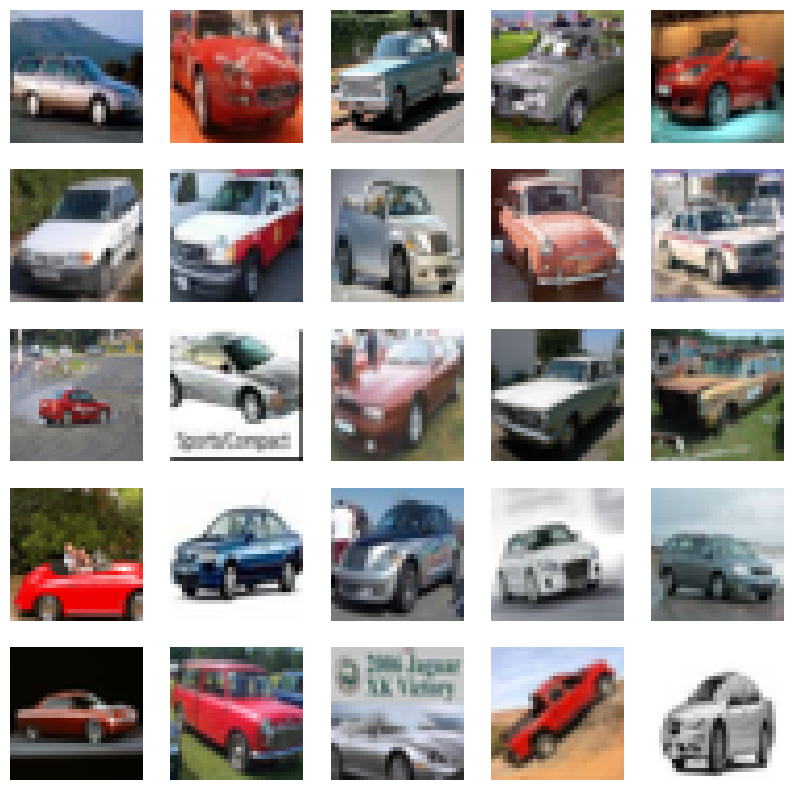

In [9]:
for i in train_dataset.take(1):
    print(i.shape)
show_sample_imgs(i[:32])

In [10]:
IMG_SIZE = 32
TIMESTEPS = 4
time_bar = 1 - np.linspace(0, 1.0, TIMESTEPS + 1)
time_bar

array([1.  , 0.75, 0.5 , 0.25, 0.  ])

In [11]:
def forward_noise(x, t):
    # time_bar[t] gives amount of noise to be included at time t and t+1 
    a = tf.reshape(time_bar[t], (-1, 1, 1, 1))
    b = tf.reshape(time_bar[t + 1], (-1, 1, 1, 1))
    noise = tf.cast(tf.random.normal(shape=tf.shape(x)), tf.float64)
    img_a = x * (1.0 - tf.cast(a, tf.float64)) + noise * tf.cast(a, tf.float64)
    img_b = x * (1.0 - tf.cast(b, tf.float64)) + noise * tf.cast(b, tf.float64)
    return img_a, img_b
    
def generate_ts(batch_size,timesteps):
    return np.random.randint(0, timesteps, size=batch_size)

In [12]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

In [13]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x4 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)
    
    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

In [14]:
def custom_mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse_loss

In [15]:
model = make_model()
model_opt = tf.keras.optimizers.Adam(0.0008)
model.compile(optimizer=model_opt,loss=custom_mse_loss)

In [16]:
init_wts = model.get_weights()[0].sum()

In [17]:
checkpoint = tf.train.Checkpoint(model=model, optimizer=model_opt)

if os.path.exists(checkpoint_path):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
    loaded_wts = model.get_weights()[0].sum()
    if init_wts!=loaded_wts:
        print("Checkpoint found! Trying to resume training from last checkpoint")
        print("Model weigths from last checkpoint loaded successfully")

Checkpoint found! Trying to resume training from last checkpoint
Model weigths from last checkpoint loaded successfully


In [18]:
@tf.function
def train_step(img_batch):

    noise = tf.random.normal(shape=tf.shape(img_batch), dtype=tf.float64)
    for t in range(0,TIMESTEPS):

        noise_fact_prev = tf.reshape(time_bar[t], (-1, 1,1, 1))
        noise_fact_curr = tf.reshape(time_bar[t + 1], (-1,1, 1, 1))
        img_prev = img_batch * (1.0 - tf.cast(noise_fact_prev, tf.float64)) + noise * tf.cast(noise_fact_prev, tf.float64)
        img_curr = img_batch * (1.0 - tf.cast(noise_fact_curr, tf.float64)) + noise * tf.cast(noise_fact_curr, tf.float64)
        batch_size = img_batch.shape[0]
        img_ts = tf.random.uniform([batch_size],minval=t,maxval=t+1,dtype=tf.int32)
        
        with tf.GradientTape() as tape:
            predictions = model([img_prev,img_ts], training=True)
            loss_value = custom_mse_loss(img_curr, predictions)
    
        gradients = tape.gradient(loss_value, model.trainable_weights)
        model_opt.apply_gradients(zip(gradients, model.trainable_weights))

    return loss_value

In [19]:
EPOCHS = 100

In [20]:
for epoch in tqdm(range(INIT_EPOCH, INIT_EPOCH + EPOCHS)):
    for data in train_dataset:
        loss = train_step(img_batch=data)

    loss_arr.append(loss.numpy())
    print(f"epoch {epoch+1} > loss {loss}")
    print("===========================")

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1201 > loss 0.00043718432425521314
epoch 1202 > loss 0.000418861978687346
epoch 1203 > loss 0.000414746580645442
epoch 1204 > loss 0.0004221085400786251
epoch 1205 > loss 0.00043452359386719763
epoch 1206 > loss 0.0004930936847813427
epoch 1207 > loss 0.00044551954488269985
epoch 1208 > loss 0.00042308736010454595
epoch 1209 > loss 0.0004186097939964384
epoch 1210 > loss 0.00041735675767995417
epoch 1211 > loss 0.0004326196212787181
epoch 1212 > loss 0.000417242175899446
epoch 1213 > loss 0.0004666502063628286
epoch 1214 > loss 0.00046164108789525926
epoch 1215 > loss 0.0005183865432627499
epoch 1216 > loss 0.00043714462663047016
epoch 1217 > loss 0.0005568164051510394
epoch 1218 > loss 0.0004789728263858706
epoch 1219 > loss 0.000472803832963109
epoch 1220 > loss 0.00043842082959599793
epoch 1221 > loss 0.0004671812930610031
epoch 1222 > loss 0.00040689753950573504
epoch 1223 > loss 0.00041901253280229867
epoch 1224 > loss 0.000407924730097875
epoch 1225 > loss 0.000513601058628

In [21]:
checkpoint.save(model_save_path)

'/home/studio-lab-user/diffusion/version_4/checkpoint/model-10'

In [22]:
model_train_details = {"last_epoch" : epoch+1,"loss":loss_arr}
joblib.dump(model_train_details,model_train_details_file)

['model_train_details_4']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


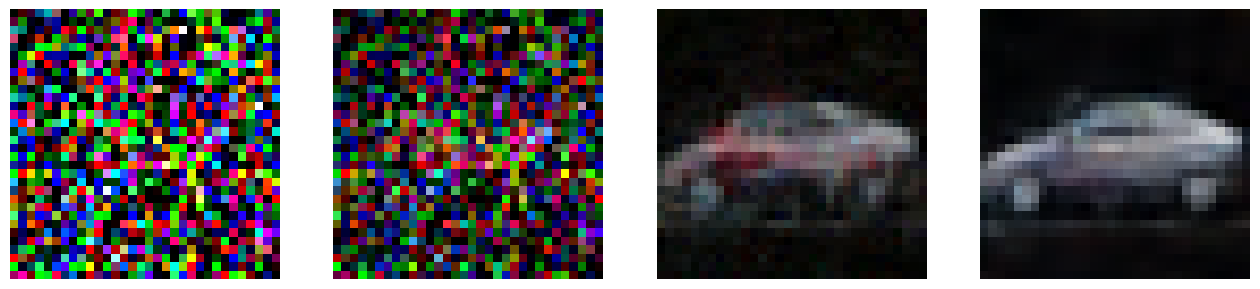

In [32]:
img = tf.cast(tf.random.normal(shape=(1,32,32,3)), tf.float64)
img_res_ls = []

for m in range(TIMESTEPS):
    img = model.predict([img,tf.random.uniform([1],minval=m,maxval=m+1)],verbose=0)
    img_res_ls.append(img)
    
plt.figure(figsize=(16,4))
for k in range(1,TIMESTEPS+1):
    plt.subplot(1,TIMESTEPS,k)
    plt.imshow(img_res_ls[k-1][0])
    plt.axis("off");

prog_img_save_path = os.path.join(progress_fold,f'image_epoch_{model_train_details.get("last_epoch")}.png')
plt.savefig(prog_img_save_path)    

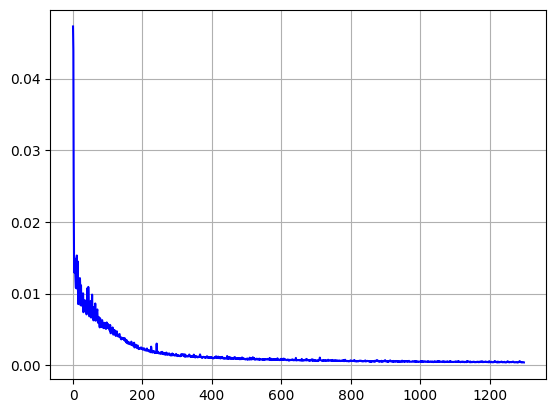

In [24]:
plt.plot(model_train_details.get("loss"),color="blue")
plt.grid(True);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


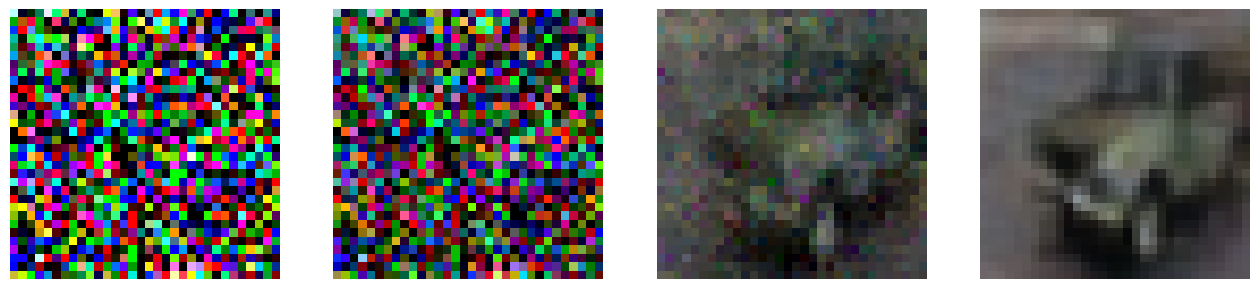

In [36]:
img = tf.cast(tf.random.normal(shape=(1,32,32,3)), tf.float64)
img_res_ls = []

for m in range(TIMESTEPS):
    img = model.predict([img,tf.random.uniform([1],minval=m,maxval=m+1)],verbose=0)
    img_res_ls.append(img)
    
plt.figure(figsize=(16,4))
for k in range(1,TIMESTEPS+1):
    plt.subplot(1,TIMESTEPS,k)
    plt.imshow(img_res_ls[k-1][0])
    plt.axis("off");